In [1]:
"""
Parametric scanner for the Bubble Column Gas-Liquid Contactor Model.

This script runs the bubble column simulation over a range of column
diameters and lengths to study their effect on extraction efficiency.
"""

import numpy as np
import matplotlib.pyplot as plt
import pathsim_chem.tritium.glc as bubble_col_glc

import morethemes as mt
mt.set_theme("lighter")

In [2]:
# Base parameters (modify as required)
base_params = {
    "c_T_in": 1.96e-2,   # mol/m^3
    "y_T2_in": 0.0,         # molar fraction of T2 in gas inlet
    "P_in": 5e5,             # Pa
    "BCs": "O-C",           # Boundary conditions: "O-C" or "C-C"
    "flow_l": 560,          # kg/s
    "flow_g": 0.19,           # mol/s
    "T": 623,               # K
    "elements": 50,         # Number of initial mesh elements for solver
}

# Define the parameter space for the scan
diameters = np.linspace(0.1, 1.0, 40)  # m
lengths = [1.0, 2.0, 3.0, 4.0, 5.0]    # m


scan_results = {}
for L in lengths:
    efficiencies = []
    print(f"Scanning L = {L} m")
    for D in diameters:
        params = base_params.copy()
        params.update({"L": L, "D": D})
        try:
            [results, solution] = bubble_col_glc.solve(params)
            eff = results.get("extraction_efficiency [fraction]")
        except Exception as e:
            print(f"  solve failed for D={D:.3f} L={L:.2f}: {e}")
            eff = np.nan
        efficiencies.append(eff)
    scan_results[L] = np.array(efficiencies)


Scanning L = 1.0 m
Scanning L = 2.0 m
Scanning L = 3.0 m
Scanning L = 4.0 m
Scanning L = 5.0 m


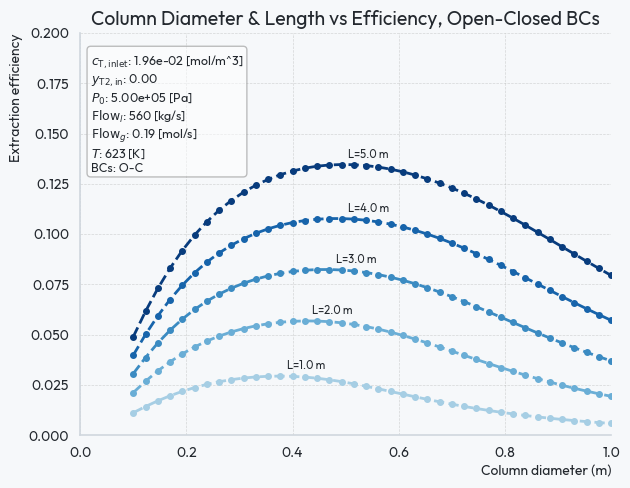

In [3]:
"""Plots the results of the parametric scan and annotates input parameters."""
plt.figure()
cmap = plt.get_cmap("Blues")
for L, efficiencies in scan_results.items():
    plt.plot(diameters, efficiencies, label=f"L = {L} m", lw=2, marker='o', markersize=4, linestyle='--', color=cmap(0.2 + 0.15 * L))
    plt.annotate(f"L={L} m", xy=(diameters[np.nanargmax(efficiencies)], np.nanmax(efficiencies)), xytext=(5, +5), textcoords='offset points', fontsize=8)
plt.xlabel("Column diameter (m)")
plt.ylabel("Extraction efficiency")

plt.ylim(0, 0.2)
plt.xlim(0, diameters.max())
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
# plt.legend()
plt.tight_layout()

# Add annotation box in top-left corner including input parameters
c_T_in = base_params.get("c_T_in")
y_T2_in = base_params.get("y_T2_in")
P_in = base_params.get("P_in")
flow_l = base_params.get("flow_l")
flow_g = base_params.get("flow_g")
T = base_params.get("T")
BCs = base_params.get("BCs")

if BCs == "C-C":
    plt.title('Column Diameter & Length vs Efficiency, Closed-Closed BCs', fontsize=14)
elif BCs == "O-C":  
    plt.title('Column Diameter & Length vs Efficiency, Open-Closed BCs', fontsize=14)

param_text = (
    f"$c_\\mathrm{{T,inlet}}$: {c_T_in:.2e} [mol/m^3]\n"
    f"$y_\\mathrm{{T2,in}}$: {y_T2_in:.2f}\n"
    f"$P_0$: {P_in:.2e} [Pa]\n"
    f"$\\mathrm{{Flow}}_l$: {flow_l:.0f} [kg/s]\n"
    f"$\\mathrm{{Flow}}_g$: {flow_g:.2f} [mol/s]\n"
    f"$T$: {T} [K]\n"
    f"BCs: {BCs}"
)

ax = plt.gca()
ax.text(
    0.02, 0.95, param_text,
    transform=ax.transAxes, fontsize=9, va='top', ha='left',
    bbox=dict(facecolor='white', alpha=0.5, edgecolor='gray', boxstyle='round')
)
plt.savefig(f"bubble_column_parametric_scan_{BCs}.pdf", bbox_inches='tight')
plt.show()